In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

## 2003~2009實驗
- **稅前** OR **稅後** 5000萬或7500萬
- +當年度ROE出場
- 本益比進場條件
- 盈再率單獨調整
- 盈再率+ROE
- 盈再率+配息

## import

In [2]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap

from dataframe import CustomDataFrame

import plot_data

In [3]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [4]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## 成分股比較

In [5]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_2000_df = pd.read_csv('./russell_component_lists/russell_2000_company.csv')
russell_3000_df = pd.read_csv('./russell_component_lists/russell_3000_company.csv')

russell_1000_symbol = russell_1000_df['Symbol'].to_list()
russell_2000_symbol = russell_2000_df['Symbol'].to_list()
russell_3000_symbol = russell_3000_df['Symbol'].to_list()

# Find elements only in russell_1000, or russell_2000, but not in russell_3000
only_russell_1000 = list(set(russell_1000_symbol) - set(russell_3000_symbol))
only_russell_2000 = list(set(russell_2000_symbol) - set(russell_3000_symbol))

print(only_russell_2000)
print(len(only_russell_2000))

# 結論 - 在羅素2000當中的公司不一定會在羅素3000

['CTV', 'PVBC', 'OVID', 'CBNK', 'ELEV', 'ATLO', 'GEOS', 'STRS', 'PCB', 'RGTI', 'TWIN', 'LCNB', 'KFS', 'RGLS', 'ANRO', 'STTK', 'RDW', 'QBTS', 'BKSY', 'FLXS', 'LLAP', 'BOLD', 'FENC', 'SBT', 'FET', 'CHMG', 'GOEV', 'NNBR', 'IVVD', 'AEYE', 'TCI', 'NATH', 'SEVN', 'SLND', 'NGS', 'BBCP', 'GCBC', 'ALCO', 'REKR', 'TRVI', 'RENB', 'COFS', 'VGAS', 'ACHV', 'VIRC', 'SGHT', 'OPAD', 'WLFC', 'SWKH', 'HRTG', 'HBB', 'METCB', 'LCUT', 'TSQ', 'PKOH', 'URG', 'NAUT', 'NTIC', 'ATLC', 'DTI', 'PYXS', 'ATNM', 'LEGH', 'NL', 'CSTE', 'BARK', 'ITI', 'ARL', 'GALT', 'ESSA', 'VSTM', 'RSVR', 'TRAK', 'MAPS', 'PRLD', 'ARQ', 'CLAR', 'VABK', 'MPX', 'NPWR', 'TLS', 'SWIM', 'GUTS', 'IBEX', 'PBFS', 'GCTS', 'XOMA', 'GLSI', 'MYFW', 'CPSS', 'CRVO', 'RELL', 'PRPL', 'CRDF', 'BELFA', 'LYRA', 'RMBL', 'MG', 'ESCA', 'NREF', 'DAVE', 'MAMA', 'EML', 'PTSI', 'JILL', 'DLHC', 'RCKY', 'INMB', 'KRT', 'VTSI', 'NATR', 'STKS', 'ATOS', 'ISPR', 'VLGEA', 'NRDY', 'ZURA', 'GAMB', 'MGX', 'SEZL', 'VRCA', 'XBIT', 'HQI', 'ADVM', 'NKSH', 'SERA', 'RLGT', 'FFNW

## get data

In [6]:
data=Data(market='US')

---

---

## 資料下載

In [7]:
close = data.get('price:close')

### **盈餘再投資率**

In [8]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
df = netIncome.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [9]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [10]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [11]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [12]:
pe = data.get('quarter_report:PE')

In [13]:
eps = data.get('quarter_report:EPS')

#### 每日本益比

In [14]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- ~~董監持股~~
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report:ROE')

In [16]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
# dpr

In [17]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [18]:
comp_profile = data.get('company_profile')
comp_profile

,company_symbol,name,ipo_date,industry
0,A,"Agilent Technologies, Inc.",1999-11-18,Medical - Diagnostics & Research
1,AA,Alcoa Corporation,2016-11-01,Aluminum
2,AAL,American Airlines Group Inc.,2005-09-27,"Airlines, Airports & Air Services"
3,AAN,"The Aaron's Company, Inc.",2020-11-25,Rental & Leasing Services
4,AAON,"AAON, Inc.",1992-12-16,Construction
...,...,...,...,...
2634,ZUMZ,Zumiez Inc.,2005-05-06,Apparel - Retail
2635,ZUO,"Zuora, Inc.",2018-04-12,Software - Infrastructure
2636,ZWS,Zurn Elkay Water Solutions Corporation,2012-03-29,Industrial - Pollution & Treatment Controls
2637,ZYME,Zymeworks Inc.,2017-04-28,Biotechnology


In [19]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date = row['ipo_date']
    end_date = listed_date + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [20]:
# ROE 5年平均 > 15%
df = roe.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [21]:
roe_cond = roe_rol > 0.15

In [22]:
rr_cond = rr < 0.4

In [23]:
netprofit_cond = netIncome > 75000000

In [24]:
bf_tax_cond = income_bf_tax > 75000000

In [25]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
df = payout_ratio.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [26]:
payout_cond = payout_ratio_rol >= 0.4

In [27]:
pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [28]:
daily_pe_entry = (pe_daily.resample('M').last() < 12)[START_DATE:END_DATE]
daily_pe_exit = (pe_daily.resample('M').last() > 30)[START_DATE:END_DATE]

In [29]:
listed_cond = listed_df.resample('M').last()

---

## 單一條件

In [30]:
roe_cond_rep = backtest.sim(roe_cond[START_DATE:END_DATE], resample='M' , data=data)
roe_cond_rep.get_stats()

{'CAGR': 0.07803381090431727,
 'daily_sharpe': 71.41,
 'max_drawdown': -0.5388225214816141,
 'avg_drawdown': -0.06887772642492536,
 'win_ratio': 0.6270096463022508,
 'ytd': -0.08925884328250411}

In [31]:
rr_cond_rep = backtest.sim(rr_cond[START_DATE:END_DATE], resample='M', data=data)
rr_cond_rep.get_stats()

{'CAGR': 0.08528867670584894,
 'daily_sharpe': 67.71,
 'max_drawdown': -0.5417528559386732,
 'avg_drawdown': -0.07048718199480712,
 'win_ratio': 0.5861423220973783,
 'ytd': -0.10686763158007695}

In [32]:
# rr_cond_rep.calc_returns_contrib()

## 所有條件不含本益比進出場

In [33]:
orig_cond_opt = (rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
orig_cond = ((rr < 0.8) & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
filtered_russell_1000_symbol = [symbol for symbol in russell_1000_symbol if symbol in close.columns]

In [34]:
len(filtered_russell_1000_symbol)

999

### 盈再率 < 40%

In [35]:
rep_orig_opt = backtest.sim(orig_cond_opt, resample='M', data=data)
rep_orig_opt.get_stats()

{'CAGR': 0.005257880924365299,
 'daily_sharpe': 111.73,
 'max_drawdown': -0.5253640334887554,
 'avg_drawdown': -0.05914298973626555,
 'win_ratio': 0.5,
 'ytd': -0.132695365660921}

In [36]:
filtered_russell_1000_symbol = [symbol for symbol in filtered_russell_1000_symbol if symbol not in ['ALAB', 'LOAR']]
# filtered_russell_1000_symbol

In [37]:
rep_orig_filter = backtest.sim(orig_cond_opt[filtered_russell_1000_symbol], resample='M', data=data)
rep_orig_filter.get_stats()

{'CAGR': 0.02133829899920814,
 'daily_sharpe': 101.06,
 'max_drawdown': -0.49979826807217664,
 'avg_drawdown': -0.05743387944384181,
 'win_ratio': 0.5833333333333334,
 'ytd': -0.1448333237292746}

### 不看配息率

#### 盈再率 < 40%

In [38]:
nodpr_cond_opt = (rr_cond & roe_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]
nodpr_cond_opt_filter = (rr_cond & roe_cond & netprofit_cond & listed_cond)[filtered_russell_1000_symbol][START_DATE:END_DATE]

In [39]:
noDPRrep_opt = backtest.sim(nodpr_cond_opt, resample='M', data=data)
noDPRrep_opt.get_stats()

{'CAGR': 0.02666955381930536,
 'daily_sharpe': 99.21,
 'max_drawdown': -0.5278689833601402,
 'avg_drawdown': -0.07188647586278854,
 'win_ratio': 0.4713375796178344,
 'ytd': -0.07460378383424615}

In [40]:
noDPRrep_opt_filt = backtest.sim(nodpr_cond_opt_filter, resample='M', data=data)
noDPRrep_opt_filt.get_stats()

{'CAGR': 0.04184243506990204,
 'daily_sharpe': 90.9,
 'max_drawdown': -0.5070386985129747,
 'avg_drawdown': -0.06596617785316225,
 'win_ratio': 0.5045871559633027,
 'ytd': -0.06907195295884727}

## 所有條件包含本益比進出場

### 盈再率 < 40%

In [41]:
opt_orig_pe = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_orig_pe_filt = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol] 

In [42]:
opt_rep_pe = backtest.sim(opt_orig_pe, resample='M', data=data)
opt_rep_pe.get_stats()

{'CAGR': 0.00816676261249416,
 'daily_sharpe': 107.4,
 'max_drawdown': -0.5310888459021046,
 'avg_drawdown': -0.06310726767441621,
 'win_ratio': 0.5333333333333333,
 'ytd': -0.1296826658404363}

In [43]:
_, _ = opt_rep_pe.calc_returns_contrib(5)

In [44]:
# annual_pe_entry = (pe_daily.resample('A-MAR').last() < 12)[START_DATE:'2007-3']
# annual_pe_exit = (pe_daily.resample('A-MAR').last() > 30)[START_DATE:'2007-3']

# opt_orig_pe_annual = (orig_cond_opt[START_DATE:'2007-3'] & annual_pe_entry[START_DATE:'2007-3']).hold_until((~orig_cond_opt[START_DATE:'2007-3']) | annual_pe_exit[START_DATE:'2007-3'])

# opt_rep_pe_annual = backtest.sim(opt_orig_pe_annual, resample='A-MAR', data=data)
# opt_rep_pe_annual.get_stats()

In [45]:
opt_rep_pe_filt = backtest.sim(opt_orig_pe_filt, resample='M', data=data)
opt_rep_pe_filt.get_stats()

{'CAGR': 0.027758697815309485,
 'daily_sharpe': 94.66,
 'max_drawdown': -0.5026436328166525,
 'avg_drawdown': -0.06117132412521264,
 'win_ratio': 0.6363636363636364,
 'ytd': -0.14315628110434042}

### 不包含配息率

### 盈再率 < 40%

In [46]:
opt_noDPR_pe = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_noDPR_pe_filt = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE])

In [47]:
rep_opt_noDPR_pe = backtest.sim(opt_noDPR_pe, resample='M', data=data)
rep_opt_noDPR_pe.get_stats()

{'CAGR': 0.02385347211740574,
 'daily_sharpe': 96.86,
 'max_drawdown': -0.5528854739756184,
 'avg_drawdown': -0.08109954332480884,
 'win_ratio': 0.4772727272727273,
 'ytd': -0.07321609621684089}

In [48]:
rep_opt_noDPR_pe_filt = backtest.sim(opt_noDPR_pe_filt, resample='M', data=data)
rep_opt_noDPR_pe_filt.get_stats()

{'CAGR': 0.04614343309852442,
 'daily_sharpe': 87.6,
 'max_drawdown': -0.5293628491200129,
 'avg_drawdown': -0.07260898869415176,
 'win_ratio': 0.5057471264367817,
 'ytd': -0.06527046013607718}

---

## 上面的入選股數比較

In [49]:
# bf_tax_cond = income_bf_tax > 75000000
orig_cond_bft = rr_cond & roe_cond & bf_tax_cond & payout_cond & listed_cond
nodpr_bft_cond = rr_cond & roe_cond & bf_tax_cond & listed_cond


overall_conds = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
overall_conds['所有條件_無本益比'] = orig_cond_opt
# overall_conds['所有條件_無本益比_稅前淨利'] = orig_cond_bft[START_DATE:END_DATE]
overall_conds['所有條件_無本益比_羅素1000'] = orig_cond_opt[filtered_russell_1000_symbol]
# overall_conds['所有條件_無本益比_稅前淨利_羅素1000'] = orig_cond_bft[START_DATE:END_DATE][filtered_russell_1000_symbol]

# overall_conds['所有條件_盈再率<80_每季本益比'] = orig_quarter_pe
overall_conds['所有條件_有本益比'] = opt_orig_pe
overall_conds['所有條件_有本益比_ROE出場條件'] = opt_orig_pe & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['所有條件_有本益比_稅前淨利'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_conds['所有條件_有本益比_羅素1000'] = opt_orig_pe_filt
overall_conds['所有條件_有本益比_羅素1000_ROE出場條件'] = opt_orig_pe_filt & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['所有條件_有本益比_稅前淨利_羅素1000'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]

# overall_conds['去掉配息盈再率<80_無本益比'] = test_cond
overall_conds['去掉配息_無本益比'] = nodpr_cond_opt
# overall_conds['去掉配息_無本益比_稅前淨利'] = nodpr_bft_cond[START_DATE:END_DATE]
overall_conds['去掉配息_無本益比_羅素1000'] = nodpr_cond_opt_filter
# overall_conds['去掉配息_無本益比_稅前淨利_羅素1000'] = nodpr_bft_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# overall_conds['去掉配息_盈再率<80_每季本益比'] = test_noDPR_pe
overall_conds['去掉配息_有本益比'] = opt_noDPR_pe
overall_conds['去掉配息_有本益比_ROE出場條件'] = opt_noDPR_pe & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['去掉配息_有本益比_稅前淨利'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_conds['去掉配息_有本益比_羅素1000'] = opt_noDPR_pe_filt
overall_conds['去掉配息_有本益比_羅素1000_ROE出場條件'] = opt_noDPR_pe_filt & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['去掉配息_有本益比_稅前淨利_羅素1000'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]


overall_conds['單一條件_ROE五年平均'] = roe_cond[START_DATE:END_DATE]
overall_conds['單一條件_ROE五年平均_羅素1000'] = roe_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]

overall_conds['單一條件_盈再率<40%'] = rr_cond[START_DATE:END_DATE]
overall_conds['單一條件_盈再率<40%_羅素1000'] = rr_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# overall_conds['單一條件_盈再率<80%'] = (rr<0.8)[START_DATE:END_DATE]


overall_conds_collecs = sim_conditions(overall_conds, resample='M', data=data)
overall_conds_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 16/16 [03:26<00:00, 12.92s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
單一條件_盈再率<40%_羅素1000,8.65,-51.50,292.38,302.0,260.0,337.0,225.0,346.0
單一條件_盈再率<40%,8.53,-54.18,560.95,573.0,475.0,666.0,408.0,703.0
單一條件_ROE五年平均_羅素1000,7.91,-52.67,231.55,219.0,201.0,263.0,197.0,302.0
單一條件_ROE五年平均,7.80,-53.88,377.73,362.0,330.0,432.0,319.0,480.0
去掉配息_有本益比_羅素1000_ROE出場條件,5.65,-51.32,71.47,64.0,52.0,82.0,39.0,146.0
所有條件_有本益比_羅素1000_ROE出場條件,4.73,-47.88,12.45,12.0,9.0,14.0,7.0,22.0
去掉配息_有本益比_羅素1000,4.61,-52.94,78.92,65.0,60.0,92.0,47.0,166.0
去掉配息_無本益比_羅素1000,4.18,-50.70,123.86,114.0,101.0,145.0,89.0,185.0
去掉配息_有本益比_ROE出場條件,3.34,-53.93,88.78,78.0,65.0,101.0,53.0,177.0


---

---

## 每季本益比

### 每年三月底（+0、15、30、45天）

In [50]:
pe_entry_AMAR = (pe.resample('A-MAR').last() < 12)[START_DATE:END_DATE]
pe_exit_AMAR = (pe.resample('A-MAR').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_AMAR = (orig_cond_opt & pe_entry_AMAR).hold_until((~orig_cond_opt) | pe_exit_AMAR)
orig_cond_opt_AMAR_rep = backtest.sim(orig_cond_opt_AMAR, resample='A-MAR', data=data)
orig_cond_opt_AMAR_rep.get_stats()

{'CAGR': 0.0403383751255344,
 'daily_sharpe': 91.68,
 'max_drawdown': -0.4928442243245005,
 'avg_drawdown': -0.06170033481117954,
 'win_ratio': 0.625,
 'ytd': -0.12526839548982083}

In [51]:
orig_cond_opt_AMAR_rep.display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,4.03%,91.68,-49.28%,62.5%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
CAG,2003-04-01,2009-04-01,2003-03-31,2009-03-31,0.142857,1511,814,2325,0.026939,-0.153034,0.597625,0.597625,-0.469860,1454.0,0.000000,0.000000
GOGL,2008-04-01,2009-04-01,2008-03-31,2009-03-31,0.100000,253,2072,2325,-0.397784,-0.550659,0.309701,0.309701,-0.656913,118.0,0.000000,0.000000
SFL,2008-04-01,2009-04-01,2008-03-31,2009-03-31,0.100000,253,2072,2325,-0.717930,-0.824826,0.220503,0.220503,-0.856474,107.0,0.000000,0.000000
ABT,2003-04-01,NaT,2003-03-31,NaT,0.142857,5420,814,-1,9.897547,-0.016038,11.675472,0.201887,-0.338791,5418.0,0.083333,0.083333
AVY,2006-04-03,NaT,2006-03-31,NaT,0.166667,4663,1571,-1,4.769898,-0.673475,5.143510,0.210159,-0.730180,3079.0,0.083333,0.083333
BMY,2008-04-01,NaT,2008-03-31,NaT,0.100000,4162,2072,-1,3.334942,-0.186567,5.183250,0.067164,-0.476733,3951.0,0.083333,0.083333
GE,2005-04-01,NaT,2005-03-31,NaT,0.111111,4916,1318,-1,0.807233,-0.779463,0.829405,0.274923,-0.827019,1591.0,0.083333,0.083333
MAT,2008-04-01,NaT,2008-03-31,NaT,0.100000,4162,2072,-1,0.386707,-0.477897,1.846536,0.028303,-0.816475,3302.0,0.083333,0.083333
MKC,2009-04-01,NaT,2009-03-31,NaT,0.083333,3909,2325,-1,6.377037,-0.030556,8.163889,0.000000,-0.411842,3889.0,0.083333,0.083333


In [52]:
orig_cond_opt_AMAR15 = (orig_cond_opt & pe_entry_AMAR).hold_until((~orig_cond_opt) | pe_exit_AMAR)
orig_cond_opt_AMAR15_rep = backtest.sim(orig_cond_opt_AMAR15, resample='A-MAR', resample_offset="15D", data=data)
orig_cond_opt_AMAR15_rep.get_stats()

{'CAGR': 0.027624745819498253,
 'daily_sharpe': 97.43,
 'max_drawdown': -0.5026563481561518,
 'avg_drawdown': -0.0646625075604943,
 'win_ratio': 0.6875,
 'ytd': -0.1268258115347367}

In [53]:
orig_cond_opt_AMAR30 = (orig_cond_opt & pe_entry_AMAR).hold_until((~orig_cond_opt) | pe_exit_AMAR)
orig_cond_opt_AMAR30_rep = backtest.sim(orig_cond_opt_AMAR30, resample='A-MAR', resample_offset="30D", data=data)
orig_cond_opt_AMAR30_rep.get_stats()

{'CAGR': 0.02299729257160732,
 'daily_sharpe': 99.21,
 'max_drawdown': -0.5065469160772537,
 'avg_drawdown': -0.06642978337059377,
 'win_ratio': 0.6875,
 'ytd': -0.12708641926454733}

In [54]:
orig_cond_opt_AMAR45 = (orig_cond_opt & pe_entry_AMAR).hold_until((~orig_cond_opt) | pe_exit_AMAR)
orig_cond_opt_AMAR45_rep = backtest.sim(orig_cond_opt_AMAR45, resample='A-MAR', resample_offset="45D", data=data)
orig_cond_opt_AMAR45_rep.get_stats()

{'CAGR': 0.013726868842790507,
 'daily_sharpe': 108.75,
 'max_drawdown': -0.49787479323164174,
 'avg_drawdown': -0.06953020796922009,
 'win_ratio': 0.6,
 'ytd': -0.1287986385773766}

### 每年年底 (12/31)

In [55]:
pe_entry_A = (pe.resample('A').last() < 12)[START_DATE:END_DATE]
pe_exit_A = (pe.resample('A').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_A = (orig_cond_opt & pe_entry_A).hold_until((~orig_cond_opt) | pe_exit_A)
orig_cond_opt_A_rep = backtest.sim(orig_cond_opt_A, resample='A', data=data)
orig_cond_opt_A_rep.get_stats()

{'CAGR': -0.017826023947620562,
 'daily_sharpe': 78.95,
 'max_drawdown': -0.6017949782920782,
 'avg_drawdown': -0.07984346845376945,
 'win_ratio': 0.5,
 'ytd': -0.145917102213584}

### 每季 (3、6、9、12月)

In [56]:
pe_entry_Q = (pe.resample('Q').last() < 12)[START_DATE:END_DATE]
pe_exit_Q = (pe.resample('Q').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_Q = (orig_cond_opt & pe_entry_Q).hold_until((~orig_cond_opt) | pe_exit_Q)
orig_cond_opt_Q_rep = backtest.sim(orig_cond_opt_Q, resample='Q', data=data)
orig_cond_opt_Q_rep.get_stats()

{'CAGR': 0.014711937043311973,
 'daily_sharpe': 101.89,
 'max_drawdown': -0.54097170303038,
 'avg_drawdown': -0.06694857450371747,
 'win_ratio': 0.4666666666666667,
 'ytd': -0.16465084175563338}

### 每月（月初MS、月中MS+15、月底）

In [57]:
pe_entry_M = (pe.resample('M').last() < 12)[START_DATE:END_DATE]
pe_exit_M = (pe.resample('M').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_MS = (orig_cond_opt & pe_entry_M).hold_until((~orig_cond_opt) | pe_exit_M)
orig_cond_opt_MS_rep = backtest.sim(orig_cond_opt_MS, resample='MS', data=data)
orig_cond_opt_MS_rep.get_stats()

{'CAGR': 0.003257592248189889,
 'daily_sharpe': 105.95,
 'max_drawdown': -0.5638634753459679,
 'avg_drawdown': -0.06852987830331081,
 'win_ratio': 0.4838709677419355,
 'ytd': -0.14750977408060706}

In [58]:
orig_cond_opt_MS15 = (orig_cond_opt & pe_entry_M).hold_until((~orig_cond_opt) | pe_exit_M)
orig_cond_opt_MS15_rep = backtest.sim(orig_cond_opt_MS15, resample='MS', resample_offset="15D", data=data)
orig_cond_opt_MS15_rep.get_stats()

{'CAGR': -0.004341866021073115,
 'daily_sharpe': 103.85,
 'max_drawdown': -0.57696063709263,
 'avg_drawdown': -0.07230181010565807,
 'win_ratio': 0.53125,
 'ytd': -0.1623398873158729}

In [59]:
orig_cond_opt_M = (orig_cond_opt & pe_entry_M).hold_until((~orig_cond_opt) | pe_exit_M)
orig_cond_opt_M_rep = backtest.sim(orig_cond_opt_M, resample='M', data=data)
orig_cond_opt_M_rep.get_stats()

{'CAGR': 0.008758815357014171,
 'daily_sharpe': 103.19,
 'max_drawdown': -0.5673957019054114,
 'avg_drawdown': -0.06839032181522954,
 'win_ratio': 0.41935483870967744,
 'ytd': -0.15256069724856025}

### 每週、每兩週

In [60]:
pe_entry_W = (pe.resample('W').last() < 12)[START_DATE:END_DATE]
pe_exit_W = (pe.resample('W').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_W = (orig_cond_opt & pe_entry_W).hold_until((~orig_cond_opt) | pe_exit_W)
orig_cond_opt_W_rep = backtest.sim(orig_cond_opt_W, resample='W', data=data)
orig_cond_opt_W_rep.get_stats()

{'CAGR': -0.0009934325524969534,
 'daily_sharpe': 101.78,
 'max_drawdown': -0.5712158026770322,
 'avg_drawdown': -0.07024701246635004,
 'win_ratio': 0.5,
 'ytd': -0.16033561509128236}

In [61]:
pe_entry_2W = (pe.resample('2W').last() < 12)[START_DATE:END_DATE]
pe_exit_2W = (pe.resample('2W').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_2W = (orig_cond_opt & pe_entry_2W).hold_until((~orig_cond_opt) | pe_exit_2W)
orig_cond_opt_2W_rep = backtest.sim(orig_cond_opt_2W, resample='2W', data=data)
orig_cond_opt_2W_rep.get_stats()

{'CAGR': -0.008171877358168711,
 'daily_sharpe': 109.13,
 'max_drawdown': -0.579884602169477,
 'avg_drawdown': -0.07849500236950024,
 'win_ratio': 0.53125,
 'ytd': -0.14382015936168968}

### 每日

In [62]:
pe_entry_D = (pe.resample('D').last() < 12)[START_DATE:END_DATE]
pe_exit_D = (pe.resample('D').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_D = (orig_cond_opt & pe_entry_D).hold_until((~orig_cond_opt) | pe_exit_D)
orig_cond_opt_D_rep = backtest.sim(orig_cond_opt_D, resample='D', data=data)
orig_cond_opt_D_rep.get_stats()

{'CAGR': -0.0021295915458323655,
 'daily_sharpe': 111.53,
 'max_drawdown': -0.5711779577861424,
 'avg_drawdown': -0.0729216765291581,
 'win_ratio': 0.4375,
 'ytd': -0.15964193496005696}

---

## 每日本益比

### 每年三月底（+0、15、30、45天）

In [63]:
pe_entry_AMAR_daily = (pe_daily.resample('A-MAR').last() < 12)[START_DATE:END_DATE]
pe_exit_AMAR_daily = (pe_daily.resample('A-MAR').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_AMAR_daily = (orig_cond_opt & pe_entry_AMAR_daily).hold_until((~orig_cond_opt) | pe_exit_AMAR_daily)
orig_cond_opt_AMAR_rep_daily = backtest.sim(orig_cond_opt_AMAR_daily, resample='A-MAR', data=data)
orig_cond_opt_AMAR_rep_daily.get_stats()

{'CAGR': 0.015741017428554827,
 'daily_sharpe': 93.56,
 'max_drawdown': -0.5503740068136217,
 'avg_drawdown': -0.06456040933365967,
 'win_ratio': 0.4642857142857143,
 'ytd': -0.1838581010841397}

In [64]:
orig_cond_opt_AMAR15_daily = (orig_cond_opt & pe_entry_AMAR_daily).hold_until((~orig_cond_opt) | pe_exit_AMAR_daily)
orig_cond_opt_AMAR15_rep_daily = backtest.sim(orig_cond_opt_AMAR15_daily, resample='A-MAR', resample_offset="15D", data=data)
orig_cond_opt_AMAR15_rep_daily.get_stats()

{'CAGR': 0.004588375609131834,
 'daily_sharpe': 102.33,
 'max_drawdown': -0.5437542712302879,
 'avg_drawdown': -0.06581646463491482,
 'win_ratio': 0.5357142857142857,
 'ytd': -0.18568510562158802}

In [65]:
orig_cond_opt_AMAR30_daily = (orig_cond_opt & pe_entry_AMAR_daily).hold_until((~orig_cond_opt) | pe_exit_AMAR_daily)
orig_cond_opt_AMAR30_rep_daily = backtest.sim(orig_cond_opt_AMAR30_daily, resample='A-MAR', resample_offset="30D", data=data)
orig_cond_opt_AMAR30_rep_daily.get_stats()

{'CAGR': -0.0034705326421783367,
 'daily_sharpe': 104.37,
 'max_drawdown': -0.5466701551901363,
 'avg_drawdown': -0.06981550608545349,
 'win_ratio': 0.5357142857142857,
 'ytd': -0.1832136429320127}

In [66]:
orig_cond_opt_AMAR45_daily = (orig_cond_opt & pe_entry_AMAR_daily).hold_until((~orig_cond_opt) | pe_exit_AMAR_daily)
orig_cond_opt_AMAR45_rep_daily = backtest.sim(orig_cond_opt_AMAR45_daily, resample='A-MAR', resample_offset="45D", data=data)
orig_cond_opt_AMAR45_rep_daily.get_stats()

{'CAGR': -0.010648264836671029,
 'daily_sharpe': 108.52,
 'max_drawdown': -0.5460552332571385,
 'avg_drawdown': -0.07296934111601579,
 'win_ratio': 0.5,
 'ytd': -0.18644430743929974}

### 每年年底 (12/31)

In [67]:
pe_entry_A_daily = (pe_daily.resample('A').last() < 12)[START_DATE:END_DATE]
pe_exit_A_daily = (pe_daily.resample('A').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_A_daily = (orig_cond_opt & pe_entry_A_daily).hold_until((~orig_cond_opt) | pe_exit_A_daily)
orig_cond_opt_A_rep_daily = backtest.sim(orig_cond_opt_A_daily, resample='A', data=data)
orig_cond_opt_A_rep_daily.get_stats()

{'CAGR': -0.01959567336382706,
 'daily_sharpe': 110.21,
 'max_drawdown': -0.5072891592296895,
 'avg_drawdown': -0.06678014113975674,
 'win_ratio': 0.46153846153846156,
 'ytd': -0.14492240009639457}

In [68]:
orig_cond_opt_A_rep_daily.display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,-1.96%,110.21,-50.73%,46.15%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
AJG,2008-01-02,2010-01-04,2007-12-31,2009-12-31,0.066667,505,2011,2516,0.041389,-0.332639,0.235417,0.235417,-0.459809,373.0,0.000000,0.000000
BXP,2008-01-02,2010-01-04,2007-12-31,2009-12-31,0.066667,505,2011,2516,-0.227861,-0.648578,0.140969,0.140969,-0.691997,122.0,0.000000,0.000000
CMA,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,0.458681,-0.410464,0.523950,0.000000,-0.410464,164.0,0.000000,0.000000
CNS,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,1.130000,-0.244000,1.316000,0.182000,-0.360406,210.0,0.000000,0.000000
EXC,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,-0.118865,-0.290767,0.011484,0.011484,-0.298819,6.0,0.000000,0.000000
GOGL,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,-0.114280,-0.270039,0.115564,0.107782,-0.341061,46.0,0.000000,0.000000
LLY,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,-0.076562,-0.313903,0.000000,0.000000,-0.313903,0.0,0.000000,0.000000
SFL,2009-01-02,2010-01-04,2008-12-31,2009-12-31,0.035714,252,2264,2516,0.310312,-0.646230,0.339844,0.121094,-0.684443,157.0,0.000000,0.000000
ABT,2004-01-02,NaT,2003-12-31,NaT,0.083333,5229,1005,-1,7.911296,-0.153549,9.367284,0.003086,-0.338791,4961.0,0.038462,0.038462


### 每季 (3、6、9、12月)

In [69]:
pe_entry_Q_daily = (pe_daily.resample('Q').last() < 12)[START_DATE:END_DATE]
pe_exit_Q_daily = (pe_daily.resample('Q').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_Q_daily = (orig_cond_opt & pe_entry_Q_daily).hold_until((~orig_cond_opt) | pe_exit_Q_daily)
orig_cond_opt_Q_rep_daily = backtest.sim(orig_cond_opt_Q_daily, resample='Q', data=data)
orig_cond_opt_Q_rep_daily.get_stats()

{'CAGR': 0.01366840264586755,
 'daily_sharpe': 105.92,
 'max_drawdown': -0.5187415221071764,
 'avg_drawdown': -0.061325580523951005,
 'win_ratio': 0.5,
 'ytd': -0.13481557094141405}

### 每月（月初MS、月中MS+15、月底）

In [70]:
pe_entry_M_daily = (pe_daily.resample('M').last() < 12)[START_DATE:END_DATE]
pe_exit_M_daily = (pe_daily.resample('M').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_MS_daily = (orig_cond_opt & pe_entry_M_daily).hold_until((~orig_cond_opt) | pe_exit_M_daily)
orig_cond_opt_MS_rep_daily = backtest.sim(orig_cond_opt_MS_daily, resample='MS', data=data)
orig_cond_opt_MS_rep_daily.get_stats()

{'CAGR': 0.0020876772517812725,
 'daily_sharpe': 109.94,
 'max_drawdown': -0.5300287599731082,
 'avg_drawdown': -0.06325486771139434,
 'win_ratio': 0.5333333333333333,
 'ytd': -0.12987455695600725}

In [71]:
orig_cond_opt_MS15_daily = (orig_cond_opt & pe_entry_M_daily).hold_until((~orig_cond_opt) | pe_exit_M_daily)
orig_cond_opt_MS15_rep_daily = backtest.sim(orig_cond_opt_MS15_daily, resample='MS', resample_offset="15D", data=data)
orig_cond_opt_MS15_rep_daily.get_stats()

{'CAGR': -0.0034790809468835393,
 'daily_sharpe': 112.19,
 'max_drawdown': -0.5374599870582358,
 'avg_drawdown': -0.06755483352246058,
 'win_ratio': 0.5333333333333333,
 'ytd': -0.1314545113302873}

In [72]:
orig_cond_opt_M_daily = (orig_cond_opt & pe_entry_M_daily).hold_until((~orig_cond_opt) | pe_exit_M_daily)
orig_cond_opt_M_rep_daily = backtest.sim(orig_cond_opt_M_daily, resample='M', data=data)
orig_cond_opt_M_rep_daily.get_stats()

{'CAGR': 0.00816676261249416,
 'daily_sharpe': 107.4,
 'max_drawdown': -0.5310888459021046,
 'avg_drawdown': -0.06310726767441621,
 'win_ratio': 0.5333333333333333,
 'ytd': -0.1296826658404363}

### 每週、每兩週

In [73]:
pe_entry_W_daily = (pe_daily.resample('W').last() < 12)[START_DATE:END_DATE]
pe_exit_W_daily = (pe_daily.resample('W').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_W_daily = (orig_cond_opt & pe_entry_W_daily).hold_until((~orig_cond_opt) | pe_exit_W_daily)
orig_cond_opt_W_rep_daily = backtest.sim(orig_cond_opt_W_daily, resample='W', data=data)
orig_cond_opt_W_rep_daily.get_stats()

{'CAGR': 0.009277032816254138,
 'daily_sharpe': 110.63,
 'max_drawdown': -0.518733817160851,
 'avg_drawdown': -0.06296022659140717,
 'win_ratio': 0.5625,
 'ytd': -0.11090905340497859}

In [74]:
pe_entry_2W_daily = (pe_daily.resample('2W').last() < 12)[START_DATE:END_DATE]
pe_exit_2W_daily = (pe_daily.resample('2W').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_2W_daily = (orig_cond_opt & pe_entry_2W_daily).hold_until((~orig_cond_opt) | pe_exit_2W_daily)
orig_cond_opt_2W_rep_daily = backtest.sim(orig_cond_opt_2W_daily, resample='2W', data=data)
orig_cond_opt_2W_rep_daily.get_stats()

{'CAGR': 0.0005735646037643427,
 'daily_sharpe': 114.0,
 'max_drawdown': -0.5283916136871849,
 'avg_drawdown': -0.06571998822231029,
 'win_ratio': 0.5161290322580645,
 'ytd': -0.10328696537743076}

### 每日

In [75]:
pe_entry_D_daily = (pe_daily.resample('D').last() < 12)[START_DATE:END_DATE]
pe_exit_D_daily = (pe_daily.resample('D').last() > 30)[START_DATE:END_DATE]

orig_cond_opt_D_daily = (orig_cond_opt & pe_entry_D_daily).hold_until((~orig_cond_opt) | pe_exit_D_daily)
orig_cond_opt_D_rep_daily = backtest.sim(orig_cond_opt_D_daily, resample='D', data=data)
orig_cond_opt_D_rep_daily.get_stats()

{'CAGR': 0.014233851425118349,
 'daily_sharpe': 113.12,
 'max_drawdown': -0.5155137825791104,
 'avg_drawdown': -0.0643050880132907,
 'win_ratio': 0.5757575757575758,
 'ytd': -0.09873304695199814}

---

In [76]:
test_all_periods = {}
orig_cond_opts = rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond

for i in range (2004, 2025):

    daily_pe_entry_2003 = (pe_daily.resample('M').last() < 12)['2003-3':f"{i}-3-31"]
    daily_pe_exit_2003 = (pe_daily.resample('M').last() > 30)['2003-3':f"{i}-3-31"]
    
    test_all_periods[f'回測期間_{START_DATE}-03-31~{i}-03-31'] = (orig_cond_opts[START_DATE:f"{i}-3-31"] & daily_pe_entry_2003).hold_until((~orig_cond_opts[START_DATE:f"{i}-3-31"]) | daily_pe_exit_2003)

test_all_periods_combs = sim_conditions(test_all_periods, resample='M', data=data)
test_all_periods_combs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 21/21 [00:56<00:00,  2.70s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
回測期間_2003-3-31-03-31~2004-03-31,29.14,-6.16,16.15,16.0,16.0,17.0,15.0,18.0
回測期間_2003-3-31-03-31~2005-03-31,18.25,-6.67,16.88,17.0,16.0,18.0,13.0,19.0
回測期間_2003-3-31-03-31~2007-03-31,13.86,-7.07,14.51,13.0,12.0,17.0,11.0,19.0
回測期間_2003-3-31-03-31~2006-03-31,12.85,-7.07,15.27,16.0,12.0,18.0,11.0,19.0
回測期間_2003-3-31-03-31~2021-03-31,12.03,-53.11,23.10,25.0,18.0,27.0,11.0,38.0
回測期間_2003-3-31-03-31~2022-03-31,11.48,-53.11,22.76,25.0,18.0,27.0,11.0,38.0
回測期間_2003-3-31-03-31~2013-03-31,11.27,-53.11,20.63,21.0,13.0,26.0,11.0,32.0
回測期間_2003-3-31-03-31~2014-03-31,11.08,-53.11,21.11,24.0,15.0,27.0,11.0,32.0
回測期間_2003-3-31-03-31~2023-03-31,11.01,-53.11,22.65,24.0,18.0,27.0,11.0,38.0


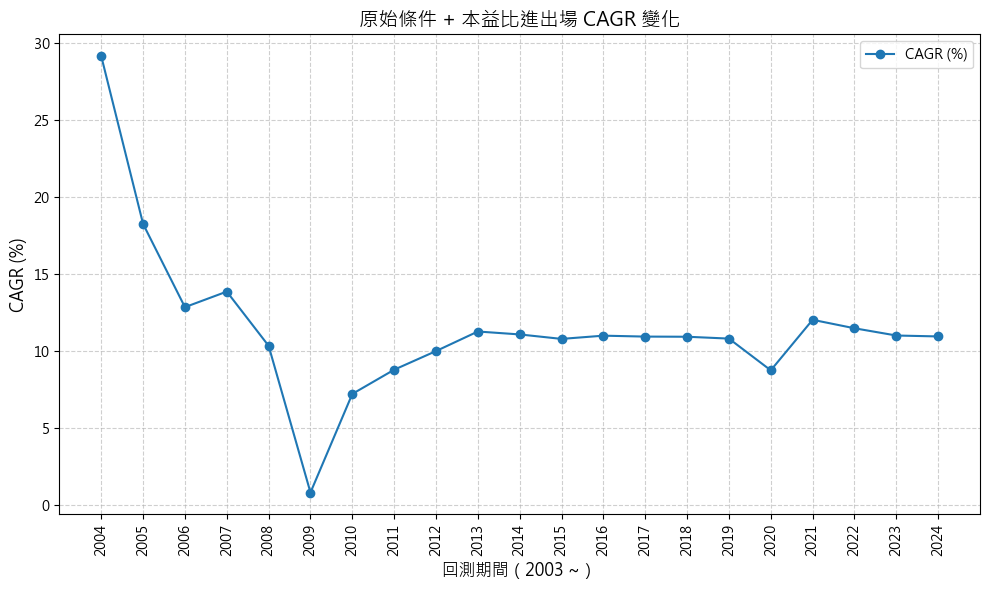

In [77]:
import re

df = test_all_periods_combs.selected_stock_count_analysis()

# 從索引中提取年份並創建臨時排序列
df['sort_year'] = df.index.map(lambda x: int(re.search(r'~(\d{4})', x).group(1)))

# 根據年份排序
df_sorted = df.sort_values('sort_year')

# 繪製折線圖
plt.figure(figsize=(10, 6))
plt.plot(df_sorted["sort_year"], df_sorted["CAGR (%)"], marker='o', linestyle='-', label="CAGR (%)")

# 設置X軸標籤旋轉和顯示整數
plt.xticks(df_sorted["sort_year"], rotation=90, fontsize=10)
plt.xlabel("回測期間（2003 ~）", fontsize=12)
plt.ylabel("CAGR (%)", fontsize=12)
plt.title("原始條件 + 本益比進出場 CAGR 變化", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# 顯示圖表
plt.show()


In [79]:
# test_all_periods_combs.reports['原始條件_本益比進出場_2003-3-31~2024-03-31'].display()

In [80]:
test_all_periods_2009 = {}
orig_cond_opts_2009 = rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond

for i in range (2010, 2025):

    daily_pe_entry_2009 = (pe_daily.resample('M').last() < 12)['2009-3':f"{i}-3-31"]
    daily_pe_exit_2009 = (pe_daily.resample('M').last() > 30)['2009-3':f"{i}-3-31"]
    
    test_all_periods_2009[f'原始條件_本益比進出場_2009~{i}-03-31'] = (orig_cond_opts['2009-3':f"{i}-3-31"] & daily_pe_entry_2009).hold_until((~orig_cond_opts['2009-3':f"{i}-3-31"]) | daily_pe_exit_2009)

test_all_periods_combs_2009 = sim_conditions(test_all_periods_2009, resample='M', data=data)
test_all_periods_combs_2009.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 15/15 [00:16<00:00,  1.13s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
原始條件_本益比進出場_2009~2010-03-31,51.89,-6.76,26.00,26.0,26.0,26.0,24.0,27.0
原始條件_本益比進出場_2009~2011-03-31,35.28,-10.49,25.04,25.0,24.0,26.0,21.0,27.0
原始條件_本益比進出場_2009~2012-03-31,30.04,-13.51,25.78,26.0,24.0,27.0,21.0,32.0
原始條件_本益比進出場_2009~2013-03-31,28.39,-13.51,26.82,26.0,25.0,29.0,21.0,32.0
原始條件_本益比進出場_2009~2014-03-31,24.25,-13.51,26.66,26.0,25.0,28.0,21.0,32.0
原始條件_本益比進出場_2009~2015-03-31,21.32,-13.51,26.08,26.0,24.0,28.0,21.0,32.0
原始條件_本益比進出場_2009~2016-03-31,20.17,-13.51,26.06,26.0,24.0,27.0,21.0,32.0
原始條件_本益比進出場_2009~2017-03-31,18.87,-13.51,26.25,26.0,24.0,28.0,21.0,32.0
原始條件_本益比進出場_2009~2018-03-31,17.95,-13.51,26.28,26.0,25.0,28.0,21.0,32.0


---

In [90]:
roe_test_rep = backtest.sim(roe_cond['2003-3':'2009-3'], resample='M', data=data)
# roe_test_rep_df = roe_test_rep.cashflow.drop('cash')

In [169]:
roe_test_rep.trades

,stock_id,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,return,mae,gmfe,bmfe,mdd,pdays
trade_index,,,,,,,,,,,,,
0,GME,2003-04-01,2003-05-01,2003-03-31,2003-04-30,0.003135,21,-0.060790,-5.078998e-02,0.082431,0.082431,-0.123075,18.0
1,FIZZ,2003-04-01,2003-08-01,2003-03-31,2003-07-31,0.003135,85,-0.000991,-8.881784e-16,0.108108,0.072072,-0.089431,74.0
2,RL,2003-04-01,2003-08-01,2003-03-31,2003-07-31,0.003135,85,0.153763,-6.387921e-03,0.258420,0.042973,-0.097831,83.0
3,CACI,2003-04-01,2003-10-01,2003-03-31,2003-09-30,0.003135,127,0.316807,-9.638554e-02,0.448795,0.064759,-0.151344,107.0
4,CPB,2003-04-01,2003-11-03,2003-03-31,2003-10-31,0.003135,150,0.237818,-2.617801e-03,0.314136,0.026178,-0.101480,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,XOM,2003-04-01,NaT,2003-03-31,NaT,0.003135,5420,5.950995,-3.674392e-02,6.087055,0.001696,-0.623901,5382.0
774,ZBH,2009-04-01,NaT,2009-03-31,NaT,0.002141,3909,2.189129,-6.222775e-04,4.246111,0.033914,-0.497300,3907.0
775,ZD,2006-04-03,NaT,2006-03-31,NaT,0.002762,4663,1.657283,-3.948468e-01,7.094371,0.639728,-0.701910,4217.0


In [91]:
roe_test_rep_df = roe_test_rep.cashflow.drop('cash', axis=1)

In [ ]:
roe_test_rep_df_adj = (roe_test_rep_df.resample('M').last()/roe_test_rep_df.resample('M').first()-1).resample('A-MAR').sum().iloc[1:]

In [ ]:
roe_test_rep_df_adj

,A,AAL,AAON,AAP,AAPL,ABT,ABUS,ACCO,ACGL,ACIW,...,X,XOM,XRAY,YUM,ZBH,ZBRA,ZD,ZEUS,ZUMZ,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2004-03-31,0.000000,0.0,0.331053,0.000000,0.000000,0.042823,0.000000,0.0,0.000000,0.000000,...,0.0,0.149004,0.209222,0.415330,0.357726,0.428530,0.250628,0.0,0.000000,0.000000
2005-03-31,0.000000,0.0,-0.037524,0.000000,0.000000,0.138124,0.000000,0.0,0.000000,0.000000,...,0.0,0.367591,0.106275,0.296279,-0.066206,-0.063880,0.000000,0.0,0.000000,-2.202581
2006-03-31,0.000000,0.0,0.297165,0.009477,0.000000,-0.046311,0.000000,0.0,0.000000,0.000000,...,0.0,-0.095516,0.074840,-0.009173,-0.073277,0.018735,0.000000,0.0,0.000000,0.000000
2007-03-31,0.000000,0.0,0.234762,0.007352,0.000000,0.335137,0.000000,0.0,0.000000,-0.119987,...,0.0,0.240408,0.000000,0.227536,0.251626,0.000000,0.247346,0.0,0.425295,0.000000
2008-03-31,0.000000,0.0,0.115511,-0.135192,0.000000,-0.020082,0.039350,0.0,0.000000,-0.505351,...,0.0,0.103975,0.000000,0.248340,-0.083670,0.000000,-0.139671,0.0,-0.784072,0.000000
2009-03-31,0.211823,0.0,0.008882,0.268422,0.163565,-0.128151,-0.779417,0.0,-0.120985,0.000000,...,0.0,-0.030948,0.000000,-0.157163,0.000000,0.000000,0.250880,0.0,-0.224710,0.000000


In [ ]:
rr_filt = rr[roe_cond]['2003-3':'2009-3'].resample('A-MAR').last()

In [ ]:
rr_filt = rr_filt[roe_test_rep_df.columns].iloc[:-1]

In [ ]:
roe_cond_filt = roe_rol['2003-3':'2009-3'].resample('A-MAR').last()
roe_cond_filt = roe_cond_filt[roe_test_rep_df.columns].iloc[:-1]

In [ ]:
roe_cond_filt

company_symbol,A,AAL,AAON,AAP,AAPL,ABT,ABUS,ACCO,ACGL,ACIW,...,X,XOM,XRAY,YUM,ZBH,ZBRA,ZD,ZEUS,ZUMZ,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.037372,-0.708719,0.273149,0.020171,0.115924,0.299200,-0.407212,-0.460308,-0.010844,0.076370,...,0.025497,0.176739,0.169254,0.585474,0.733037,0.162496,0.710529,-0.037474,NaN,-27.012281
2004-03-31,-0.125387,-6.087095,0.272498,0.050679,0.081555,0.259610,-0.442969,-0.495762,0.020407,0.055366,...,-0.094007,0.195464,0.183481,0.772179,0.755072,0.161022,-0.079880,-0.031082,NaN,0.627001
2005-03-31,-0.136108,-5.853858,0.235944,0.128076,0.053312,0.238928,0.152276,-0.382071,0.067398,0.065609,...,-0.041108,0.220323,0.180201,1.088897,0.705830,0.151421,0.030699,0.032307,NaN,-0.334963
2006-03-31,-0.148838,-5.760008,0.195646,0.154083,0.050792,0.220702,0.300728,-0.356221,0.094428,0.103439,...,0.015832,0.235226,0.148692,1.438209,0.602249,0.139084,0.177466,0.068326,0.317495,-0.833430
2007-03-31,0.026529,-5.770659,0.176480,0.191032,0.092524,0.210906,23.596916,-0.321030,0.129839,0.184222,...,0.096185,0.262739,0.143951,0.606738,0.255482,0.127598,0.257268,0.100852,0.244857,-0.910349
2008-03-31,0.110593,-4.998969,0.178117,0.209823,0.137450,0.199083,23.686970,0.058376,0.163997,0.146417,...,0.121951,0.298718,0.142805,0.525125,0.143100,0.125187,0.255200,0.130004,0.177135,-0.812230


In [87]:
roe_cond['2002-3':'2009-3']

company_symbol,A,AA,AAL,AAN,AAON,AAP,AAPL,AAT,ABBV,ABCB,...,ZIP,ZM,ZNTL,ZS,ZTS,ZUMZ,ZUO,ZWS,ZYME,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2002-03-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2002-04-30,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2002-05-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2002-06-30,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2002-07-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-11-30,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2008-12-31,False,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2009-01-31,True,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [86]:
roe_cond['2002-3':'2008-3'].resample('A-MAR').last()

company_symbol,A,AA,AAL,AAN,AAON,AAP,AAPL,AAT,ABBV,ABCB,...,ZIP,ZM,ZNTL,ZS,ZTS,ZUMZ,ZUO,ZWS,ZYME,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2002-03-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2003-03-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2004-03-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2005-03-31,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2006-03-31,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2007-03-31,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2008-03-31,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [88]:
roe_rol['2003-3':'2009-3']

company_symbol,A,AA,AAL,AAN,AAON,AAP,AAPL,AAT,ABBV,ABCB,...,ZIP,ZM,ZNTL,ZS,ZTS,ZUMZ,ZUO,ZWS,ZYME,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.037372,NaN,-0.708719,0.110238,0.273149,0.020171,0.115924,NaN,NaN,0.096426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.172443,NaN,-27.012281
2003-04-30,0.037372,NaN,-0.708719,0.110238,0.273149,0.020171,0.115924,NaN,NaN,0.096426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.172443,NaN,-27.012281
2003-05-31,0.037372,NaN,-0.708719,0.110238,0.273149,0.020171,0.115924,NaN,NaN,0.096426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.172443,NaN,-27.012281
2003-06-30,0.037372,NaN,-0.708719,0.110238,0.273149,0.020171,0.115924,NaN,NaN,0.096426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.172443,NaN,-27.012281
2003-07-31,0.037372,NaN,-0.708719,0.110238,0.273149,0.020171,0.115924,NaN,NaN,0.096426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.172443,NaN,-27.012281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-11-30,0.110593,NaN,-4.998969,0.127249,0.178117,0.234110,0.137450,NaN,NaN,0.101878,...,NaN,NaN,NaN,NaN,NaN,0.212318,NaN,-0.188380,NaN,-0.812230
2008-12-31,0.110593,NaN,-4.998969,0.127249,0.178117,0.234110,0.177542,NaN,NaN,0.101878,...,NaN,NaN,NaN,NaN,NaN,0.212318,NaN,-0.188380,NaN,-0.812230
2009-01-31,0.310505,NaN,-4.998969,0.127249,0.178117,0.234110,0.177542,NaN,NaN,0.101878,...,NaN,NaN,NaN,NaN,NaN,0.212318,NaN,-0.188380,NaN,-0.812230


---

C:\Users\user\AppData\Local\Temp\ipykernel_10716\3764275152.py:53: RuntimeWarning:

invalid value encountered in scalar power



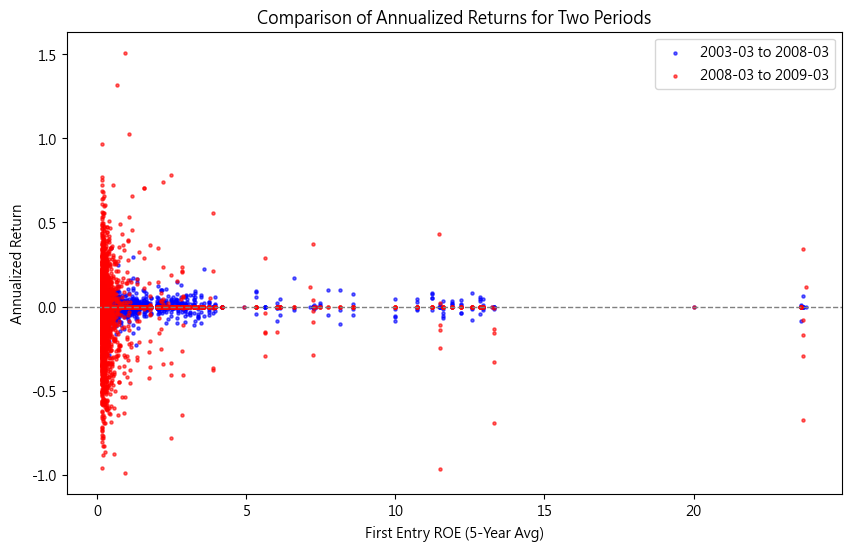

In [ ]:
# 假設已經有三個 DataFrame：roe_test_rep_df_adj, roe_cond, roe_rol
roe_test_rep_df_adj = roe_test_rep_df.resample('M').last()/roe_test_rep_df.resample('M').first()-1
roe_cond_adj = roe_cond['2003-3':'2009-3']
roe_rol_adj = roe_rol['2003-3':'2009-3']

# 設定兩個時間段的時間點
split_date = '2008-03-31'

# 初始化空的list來儲存視覺化需要的數據
roe_values = []
returns_period_1 = []
returns_period_2 = []

# 遍歷每支股票的column
for stock in roe_test_rep_df_adj.columns:
    # 找到該股票入選的時間段（roe_cond 為 True 的時間段）
    selected_periods = roe_cond_adj[roe_cond_adj[stock]].index
    
    if len(selected_periods) == 0:
        continue
    
    # 初始化分段績效
    in_position = False
    start_date = None
    
    for date in selected_periods:
        if not in_position:
            # 開始新的入選段
            start_date = date
            in_position = True
        # 如果下一個月不在入選期間或已經到最後一個日期，計算這段期間的績效
        if date == selected_periods[-1] or selected_periods[selected_periods > date].empty or selected_periods[selected_periods > date][0] != date + pd.DateOffset(months=1):
            end_date = date
            stock_returns = roe_test_rep_df_adj.loc[start_date:end_date, stock]
            
            # 根據不同的時間段進行分段累積計算
            period_1_return = stock_returns[stock_returns.index <= split_date].sum()
            period_2_return = stock_returns[stock_returns.index > split_date].sum()
            
            # 獲取首次入選的 roe_rol 值作為 X 軸數據
            first_roe_value = roe_rol_adj.loc[start_date, stock]
            
            # 儲存數據以供後續視覺化
            roe_values.append(first_roe_value)
            returns_period_1.append(period_1_return)
            returns_period_2.append(period_2_return)
            
            # 重置狀態
            in_position = False

# 年化處理（以年化回報率表示）
def annualize_return(total_return, periods):
    return ((1 + total_return) ** (12 / periods)) - 1

# 計算每支股票的年化報酬率
annual_returns_period_1 = [annualize_return(r, len(roe_test_rep_df_adj.loc[:split_date])) for r in returns_period_1]
annual_returns_period_2 = [annualize_return(r, len(roe_test_rep_df_adj.loc[split_date:])) for r in returns_period_2]

# 繪製 scatter plot
plt.figure(figsize=(10, 6))

# 第一個時間段的散佈圖
plt.scatter(roe_values, annual_returns_period_1, color='blue', alpha=0.6, label='2003-03 to 2008-03', s=5)

# 第二個時間段的散佈圖
plt.scatter(roe_values, annual_returns_period_2, color='red', alpha=0.6, label='2008-03 to 2009-03', s=5)

# 標籤與標題
plt.xlabel('First Entry ROE (5-Year Avg)')
plt.ylabel('Annualized Return')
plt.title('Comparison of Annualized Returns for Two Periods')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.legend()

# 顯示圖表
plt.show()


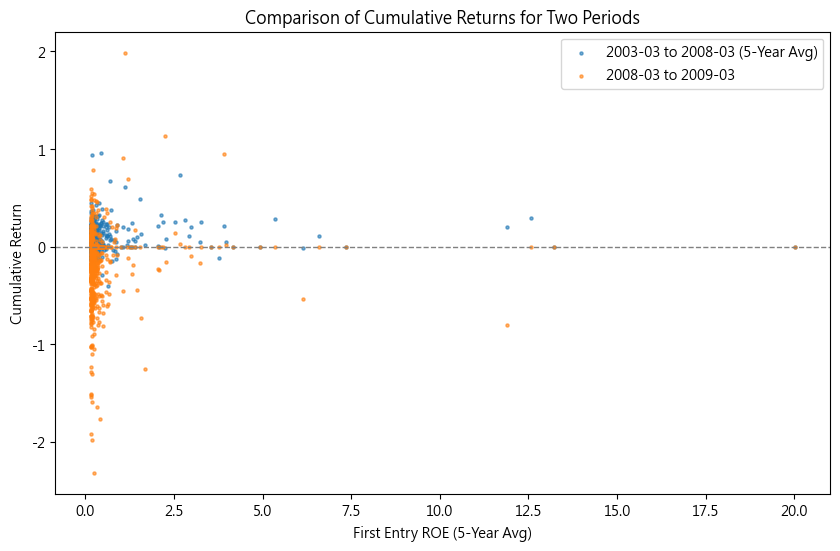

In [98]:
# 假設已經有三個 DataFrame：roe_test_rep_df_adj, roe_cond, roe_rol

# 設定兩個時間段的時間點
split_date = '2008-03-31'

# 初始化空的list來儲存視覺化需要的數據
roe_values = []
returns_period_1_avg = []
returns_period_2 = []

# 遍歷每支股票的column
for stock in roe_test_rep_df_adj.columns:
    # 找到該股票入選的時間段（roe_cond 為 True 的時間段）
    selected_periods = roe_cond_adj[roe_cond_adj[stock]].index
    
    if len(selected_periods) == 0:
        continue
    
    # 獲取首次入選的 roe_rol 值作為 X 軸數據
    first_entry_date = selected_periods[0]
    first_roe_value = roe_rol_adj.loc[first_entry_date, stock]
    
    # 獲取績效計算的起始和結束時間
    start_date = selected_periods[0]
    end_date = selected_periods[-1] if selected_periods[-1] in roe_test_rep_df_adj.index else roe_test_rep_df_adj.index[-1]
    
    # 計算績效，根據不同的時間段進行分段計算
    stock_returns = roe_test_rep_df_adj.loc[start_date:end_date, stock]
    
    # 分段計算累積報酬率
    period_1_returns = stock_returns[stock_returns.index <= split_date]
    period_2_return = stock_returns[stock_returns.index > split_date].sum()
    
    # 計算 2003-2008 年的五年平均報酬
    if len(period_1_returns) > 0:
        period_1_avg_return = period_1_returns.sum() / 5  # 五年平均
    else:
        period_1_avg_return = 0
    
    # 儲存數據以供後續視覺化
    roe_values.append(first_roe_value)
    returns_period_1_avg.append(period_1_avg_return)
    returns_period_2.append(period_2_return)

# 繪製 scatter plot
plt.figure(figsize=(10, 6))

# 第一個時間段的散佈圖
plt.scatter(roe_values, returns_period_1_avg, color='tab:blue', alpha=0.6, label='2003-03 to 2008-03 (5-Year Avg)', s=5)

# 第二個時間段的散佈圖
plt.scatter(roe_values, returns_period_2, color='tab:orange', alpha=0.6, label='2008-03 to 2009-03', s=5)

# 標籤與標題
plt.xlabel('First Entry ROE (5-Year Avg)')
plt.ylabel('Cumulative Return')
plt.title('Comparison of Cumulative Returns for Two Periods')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.legend()

# 顯示圖表
plt.show()


In [105]:
roe_rol['AAPL'][:pd.Timestamp('2008-3-31') + pd.DateOffset(days=1)][-1]

0.13744971999999997

In [ ]:
def trades_cagr_analysis_split_returns(
    factor_cond, factor, title, N=5, split_date='2008-03', start_date='2003-03', end_date='2009-03', 
    data=data, remove=False, interval_range=(15, 50, 5),
    percentage=True
):
    
    split_date = pd.Timestamp(split_date)

    
    rep = backtest.sim(factor_cond[start_date:end_date], resample='M', data=data)
    trades = rep.trades

    # 個股每月報酬率
    monthly_returns = ((rep.cashflow.resample('M').last() / rep.cashflow.resample('M').first()) - 1).resample('A-MAR').sum()

    # 分段結果存放
    x_values_first, y_values_first, stock_ids_first = [], [], []
    x_values_second, y_values_second, stock_ids_second = [], [], []

    # 逐筆查看交易明細中的個股
    for trade_id, row in trades.iterrows():
        entry_date = row['entry_sig_date']
        exit_date = row['exit_sig_date']
        stock_id = trades['stock_id'][trade_id]

        # 如果出場日為 NaN，設定 exit_date 為分析的 end_date
        if pd.isna(exit_date):
            exit_date = pd.Timestamp(end_date)

        factor_series = factor[stock_id][:pd.Timestamp(entry_date) + pd.DateOffset(days=1)].dropna()
        if not factor_series.empty:
            factor_value = factor_series.iloc[-1] * 100 if percentage else factor_series.iloc[-1]
        else:
            # 如果所有值都是 NaN，則跳過該交易
            continue

        if factor_value is not None:
            if entry_date < split_date:
                if exit_date <= split_date:
                    y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum() / (pd.Timedelta(exit_date - entry_date).days / 365)
                    x_values_first.append(factor_value)
                    y_values_first.append(y_value)
                    stock_ids_first.append(stock_id)
                else:  # 如果出場日跨越 split_date
                    y_value_first = monthly_returns.loc[entry_date:split_date, stock_id].sum() / (pd.Timedelta(split_date - entry_date).days / 365)
                    x_values_first.append(factor_value)
                    y_values_first.append(y_value_first)
                    stock_ids_first.append(stock_id)

                    y_value_second = monthly_returns.loc[split_date:exit_date, stock_id].sum()
                    x_values_second.append(factor_value)
                    y_values_second.append(y_value_second)
                    stock_ids_second.append(stock_id)
            else: # 進場日在 split_date 之後
                y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum()
                x_values_second.append(factor_value)
                y_values_second.append(y_value)
                stock_ids_second.append(stock_id)
        else:
            print(f"{stock_id} - value is None or invalid pdays for {entry_date}")

    # 去除極端值
    def filter_extreme_percent(x_values, y_values, stock_ids, N):
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        stock_ids = np.array(stock_ids)

        x_lower, x_upper = np.percentile(x_values, [N, 100 - N])
        y_lower, y_upper = np.percentile(y_values, [N, 100 - N])

        valid_indices = np.where((x_values >= x_lower) & (x_values <= x_upper) &
                                 (y_values >= y_lower) & (y_values <= y_upper))[0]

        return x_values[valid_indices], y_values[valid_indices]

    if remove:
        x_values_first, y_values_first = filter_extreme_percent(x_values_first, y_values_first, stock_ids_first, N)
        x_values_second, y_values_second = filter_extreme_percent(x_values_second, y_values_second, stock_ids_second, N)

    # 分類報酬率值的區間
    interval_start, interval_end, interval_step = interval_range
    x_labels = [f" "] + [f"{i}" for i in range(interval_start, interval_end, interval_step)] + [f"{interval_end}"]
    num_intervals = len(x_labels)

    def categorize_to_intervals(values, interval_start, interval_end, interval_step):
        categorized_values = []
        for value in values:
            if value < interval_start:
                categorized_values.append(interval_start - interval_step)
            elif value >= interval_end:
                categorized_values.append(interval_end)
            else:
                categorized_values.append(int((value - interval_start) // interval_step) * interval_step + interval_start)
        return categorized_values

    x_intervals_first = categorize_to_intervals(x_values_first, interval_start, interval_end, interval_step)
    x_intervals_second = categorize_to_intervals(x_values_second, interval_start, interval_end, interval_step)

    # 將每個點的位置根據區間偏移，保留原始相對位置，並固定區間大小，所有區間寬度一致
    def map_to_fixed_intervals(values, interval_start, interval_end, interval_step, num_intervals):
        mapped_values = []
        for value in values:
            if value >= interval_end:
                mapped_values.append(num_intervals - 1 + np.random.uniform(0.02, 0.98))
            elif value < interval_start:
                mapped_values.append(0 + np.random.uniform(0.02, 0.98))
            else:
                closest_interval = int((value - interval_start) // interval_step)
                mapped_values.append(closest_interval + 1 + np.random.uniform(0.02, 0.98))
        return mapped_values

    x_values_first_mapped = map_to_fixed_intervals(x_intervals_first, interval_start, interval_end, interval_step, num_intervals)
    x_values_second_mapped = map_to_fixed_intervals(x_intervals_second, interval_start, interval_end, interval_step, num_intervals)

    # 繪圖
    plt.figure(figsize=(12, 8))
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.6, alpha=0.6)

    plt.scatter(x_values_first_mapped, y_values_first, color='tab:blue', alpha=0.6, s=4, label=f"{start_date}~{split_date.strftime('%Y-%m')}")
    plt.scatter(x_values_second_mapped, y_values_second, color='tab:orange', alpha=0.4, s=4, label=f"{split_date.strftime('%Y-%m')}~{end_date}")

    plt.title(f"【{start_date}~{end_date}】{title} 與 股票報酬加總")
    plt.xlabel(f"一開始進場時的{title}")
    plt.ylabel("個別股票的月度報酬加總")
    plt.xticks(ticks=np.arange(num_intervals), labels=x_labels)
    plt.legend()
    plt.grid(True)

    plt.show()


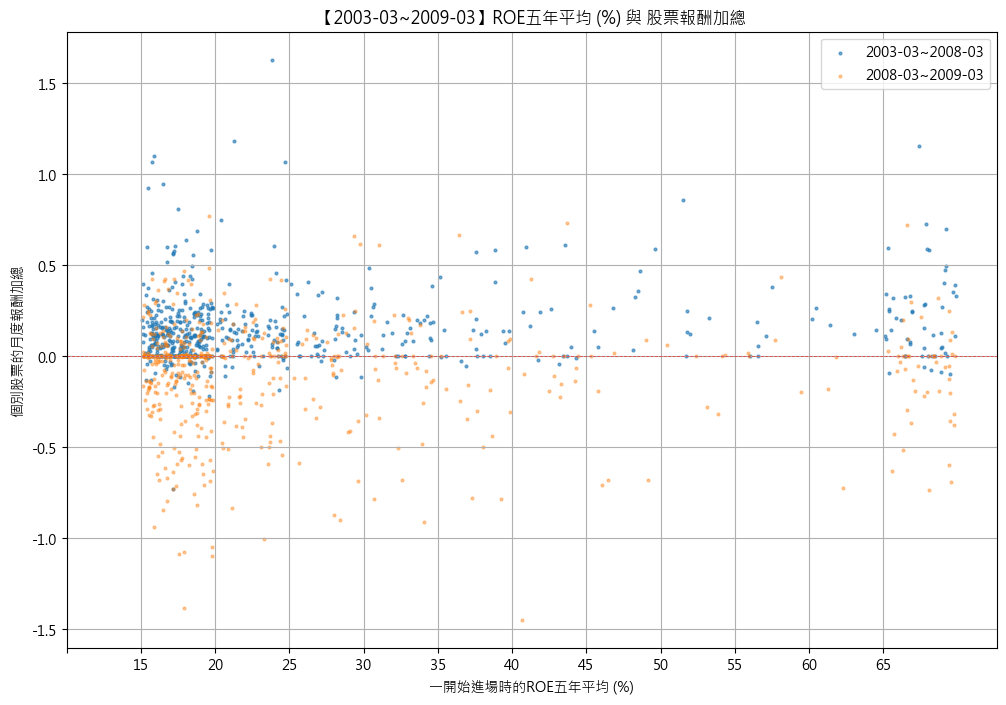

In [242]:
trades_cagr_analysis_split_returns(roe_cond, roe_rol, 'ROE五年平均 (%)', N=0.2, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True,
                                       interval_range=(15, 65, 5), percentage=True)

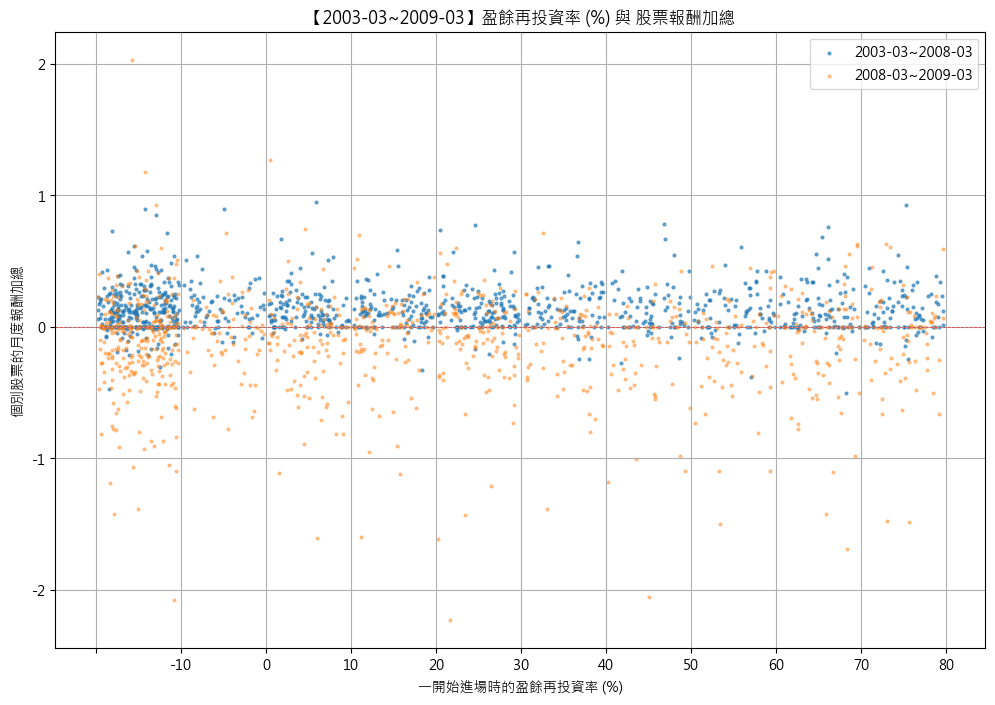

In [243]:
trades_cagr_analysis_split_returns(rr < 0.8, rr, '盈餘再投資率 (%)', N=0.1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True, interval_range=(-10, 80, 10))

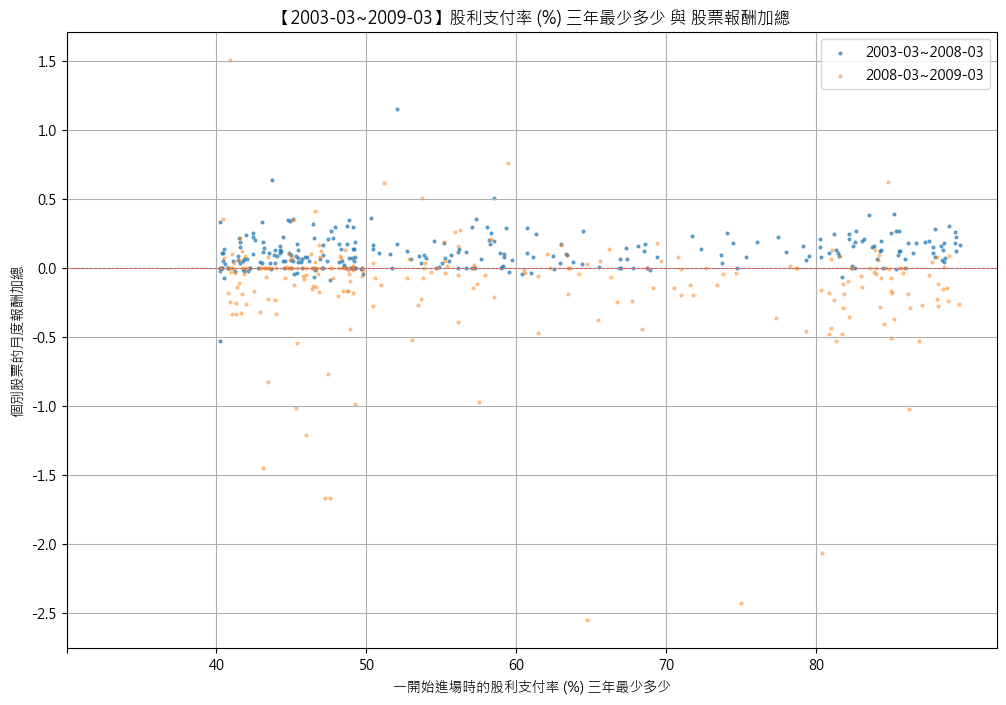

In [245]:
trades_cagr_analysis_split_returns(payout_cond, payout_ratio_rol, '股利支付率 (%) 三年最少多少', N=0.5, 
split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False, interval_range=(40, 80, 10))

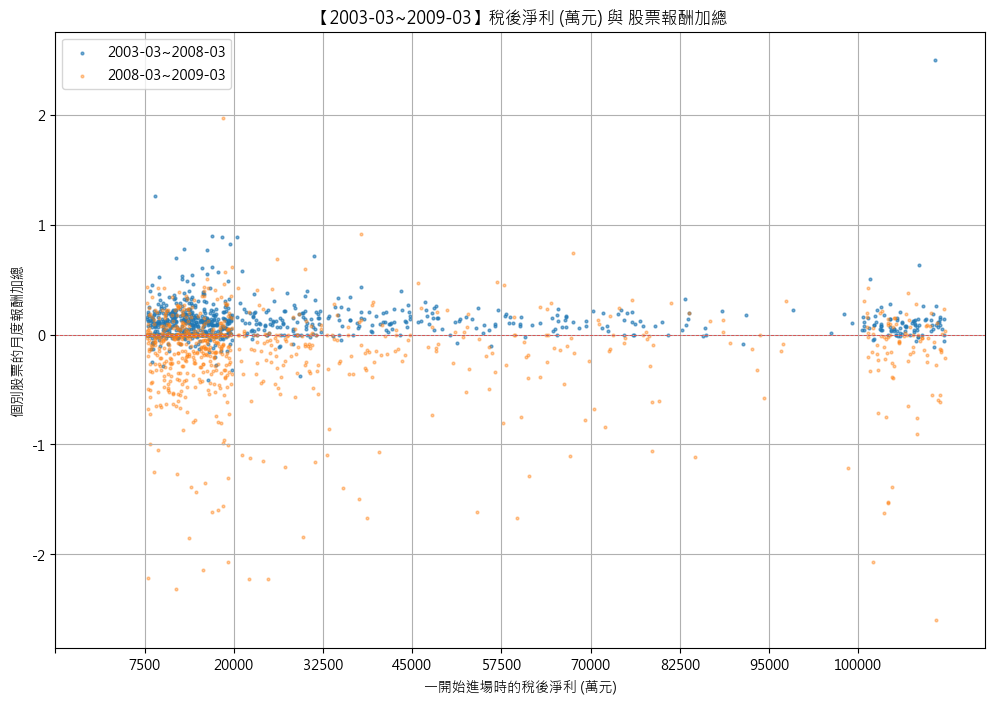

In [239]:
trades_cagr_analysis_split_returns(netprofit_cond, netIncome, '稅後淨利 (萬元)', N=0.1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False,interval_range=(7500, 100000, 12500),percentage=False)

---

In [ ]:
us_benchmark = data.get('ruaindex:close')

In [ ]:
us_benchmark

,close
date,
1993-01-04,249.24
1993-01-05,248.64
1993-01-06,248.98
1993-01-07,247.05
1993-01-08,246.09
...,...
2024-10-04,3275.41
2024-10-07,3244.36
2024-10-08,3272.42


In [ ]:
# us_benchmark_bb = data.indicator('BBANDS', resample='D', nbdevup=2.0, nbdevdn=2.0, timeperiod=300)

import talib


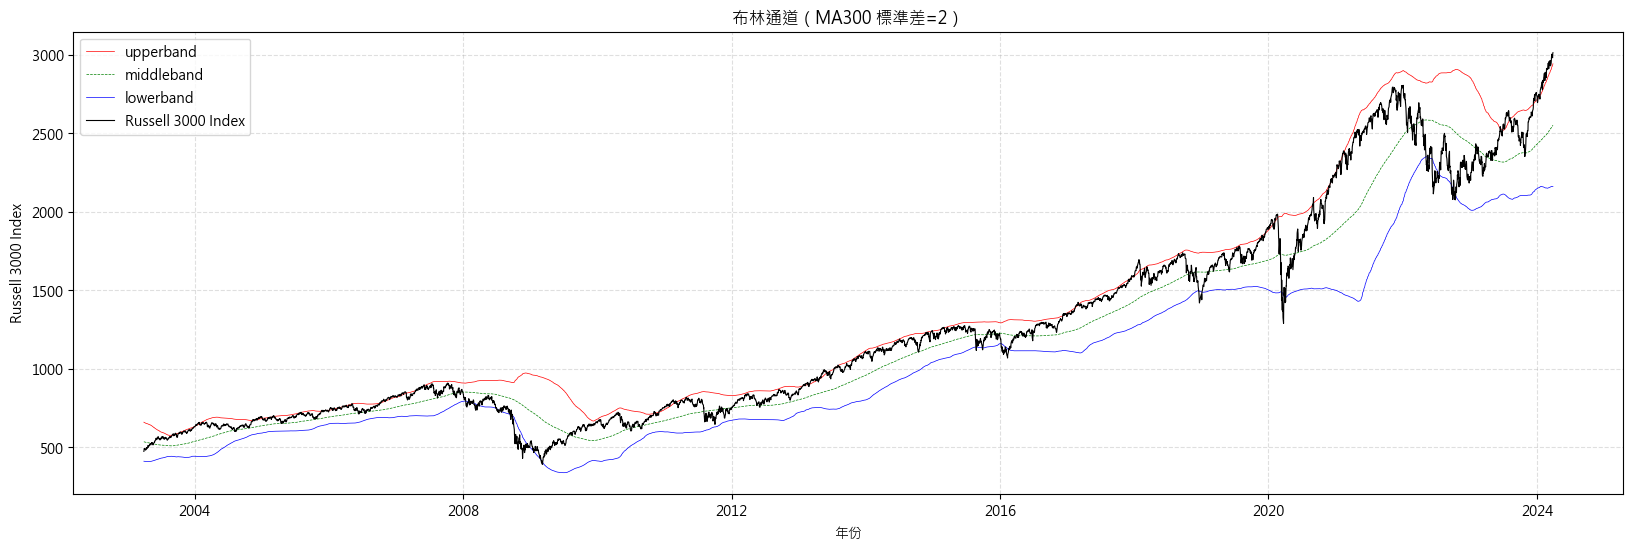

In [ ]:
upperband, middleband, lowerband = talib.BBANDS(us_benchmark.close, timeperiod=300, nbdevup=2.0, nbdevdn=2.0)


plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-03-31':'2024-03-31'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-03-31':'2024-03-31'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-03-31':'2024-03-31'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(us_benchmark['2003-03-31':'2024-03-31'],
         label="Russell 3000 Index",color='black', linewidth=0.8)



plt.title("布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("Russell 3000 Index")

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

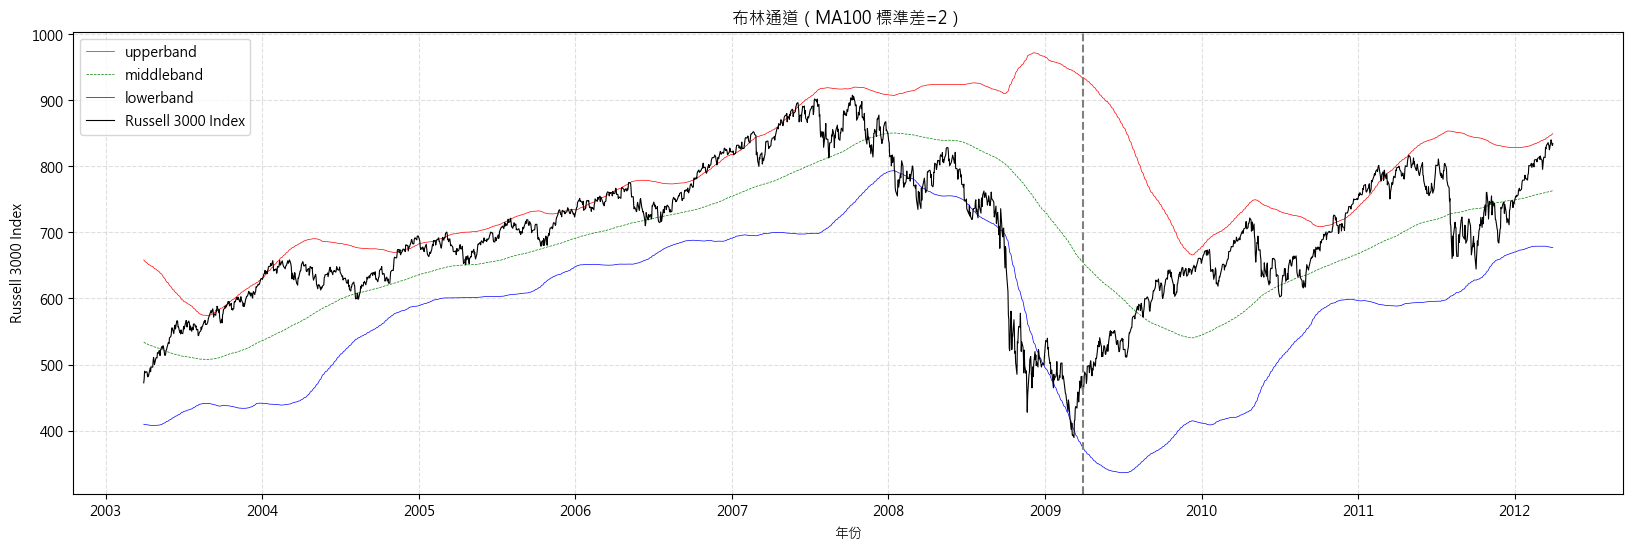

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-03-31':'2012-03-31'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-03-31':'2012-03-31'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-03-31':'2012-03-31'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(us_benchmark['2003-03-31':'2012-03-31'],
         label="Russell 3000 Index",color='black', linewidth=0.8)



plt.title("布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("Russell 3000 Index")

plt.axvline(pd.Timestamp('2009-03-31'), color='gray', linestyle='--')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()